In [1]:
include("TidalLoveNumbersPorousK23.jl")
using .TidalLoveNumbers
using DoubleFloats
using PyPlot
using Statistics
using PyCall
using BenchmarkTools
    
@pyimport seaborn as sns
@pyimport matplotlib as mpl
@pyimport matplotlib.gridspec as gspec
#
PyPlot.isjulia_display[] = false;

PyPlot.matplotlib[:rc]("font",family="Arial", weight="medium", style="normal", size=12)
PyPlot.matplotlib[:rc]("axes",titlesize=14.5, labelsize=12, unicode_minus=false)
PyPlot.matplotlib[:rc]("xtick",labelsize=11.5)
PyPlot.matplotlib[:rc]("ytick",labelsize=11.5)
PyPlot.matplotlib[:rc]("pdf",fonttype=42)
PyPlot.matplotlib[:rc]("mathtext", fontset = "stix")

# mpl.style.use("dark_background")

prec = TidalLoveNumbers.prec
precc = TidalLoveNumbers.precc

Complex{Double64}

In [2]:
non_dim = false

G = prec(6.6743e-11)
e = 0.0041

h_core = 700.0 - 690.0
h_mantle_low = 800. + 690
h_mantle_up = 300. - 0.

h_crust = 20.
ω0 = 2*2.047e-5
ω = ω0

#enceladus test model:
n = 2
ρₛ = [3300, 3300, 3300, prec(3300)]
r = [0, 
     h_core, 
     h_core+h_mantle_low, 
     h_core+h_mantle_low+h_mantle_up, 
     h_core+h_mantle_low+h_mantle_up+h_crust] .* 1e3
μ = [60+0im, 60, 60, prec(60)] .* 1e9
κ = [100e9, 100e9, 100e9, 100e9] .* 100000.0
η = [1e25, 1e25, 1e25, 1e25]

μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)

R = r[end]
μ0 = μ[end]
bp = 3
tp = 3


ρₗ = [0, 0, 3300, 0]
# α  = [0, 0, 0.95, 0., 0]
κₗ = [0, 0, 100e9, 0] .* 100000.0
κd = 0.05κ
k = [0, 0, 1e-7, 0]

ηₗ = [0, 0, 1.0, 0]
ϕ =  [0, 0, prec(0.1), 0]

ρ = (1 .- ϕ) .* ρₛ + ϕ .* ρₗ # bulk density
# ρ = ρₛ
rr = expand_layers(r)
g = get_g(rr, ρ)

 
ρ0 = ρ[end]
μ0 = ρ0*g[end,end]*R


1.00847465661513164741101953014417092e+10

In [3]:
res = 3.0
lons = deg2rad.(collect(0:res:360-0.001))'
clats = deg2rad.(collect(0:res:180))
lats = 0.5π .- clats

lons_deg = rad2deg.(lons[:])
lats_deg = 90 .- rad2deg.(clats)
dres = deg2rad(res);

# Convert lat, lon, r to xyz
function sph2cart(r, θ, ϕ)
    x = r * cos.(θ) * cos.(ϕ)
    y = r * cos.(θ) * sin.(ϕ)
    z = r * sin.(θ)
    return x, y, z
end

sph2cart (generic function with 1 method)

In [4]:
y = ComplexF64.(calculate_y(rr, ρ, g, μc, κ, ω, ρₗ, κₗ,κd, 0.95, ηₗ, ϕ, k));

U22E =  7/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1) 
U22W = -1/8 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)
U20  = -3/2 * ω0^2*R^2*e * (non_dim ? ρ0/μ0 : 1)

# global disp = get_displacement.(y[:,end,end-1], mag, 0.25π)
sol_22  = get_solution(conj.(y), 2,  2, rr, ρ, g, μc, κ, ω, ρₗ, κₗ, κd, 0.95, ηₗ, ϕ, k, res)
sol_22c = get_solution(conj.(y), 2, -2, rr, ρ, g, μc, κ, ω, ρₗ, κₗ, κd, 0.95, ηₗ, ϕ, k, res)
sol_20  = get_solution(conj.(y), 2,  0, rr, ρ, g, μc, κ, ω, ρₗ, κₗ, κd, 0.95, ηₗ, ϕ, k, res)

disp = U22E*sol_22[1] + U22W*sol_22c[1] + U20*sol_20[1] 
vel = U22E*sol_22[5] + U22W*sol_22c[5] + U20*sol_20[5] 

ϵ = U22E*sol_22[3] + U22W*sol_22c[3] + U20*sol_20[3]; 
σ = U22E*sol_22[4] + U22W*sol_22c[4] + U20*sol_20[4]; 

p = U22E*sol_22[4] + U22W*sol_22c[4] + U20*sol_20[4]; 
ζ = U22E*sol_22[6] + U22W*sol_22c[6] + U20*sol_20[6];   

In [5]:
p_t0 = p .+ conj.(p);
p_t0 ./= 1e6; # convert to MPa 

vel_t0 = vel .+ conj.(vel);


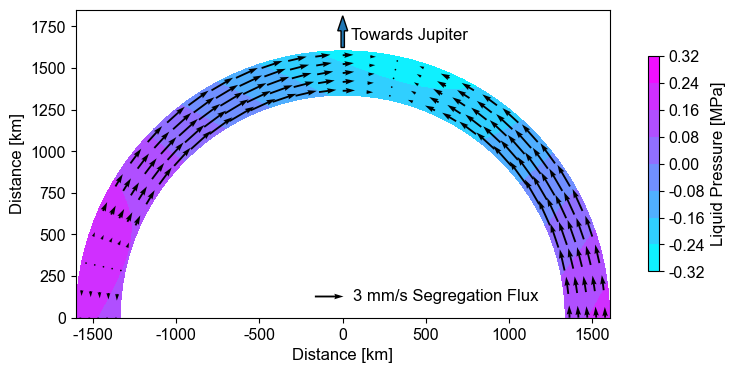

In [14]:
fig, axes = plt.subplots(ncols=1, figsize=(10,4)) 
# c = axes.contourf(lons_deg, lats_deg, real.(p_t0[:,:,150,end-1]))
# c = axes.contourf(lons_deg, rr[1:end-1,end-1]./1e3, real.(p_t0[22,:,:,end-1]'))

x, y, z = sph2cart(rr[1:end-1,end-1], lats[22], lons[1,:]') ./ 1e3

# mask1 = -x .< 0.0
mask1 = y .> 0.0

p_plot = real.(p_t0[22,:,:,end-1]');
# p_plot[mask1] .= NaN;

w_plot = real.(vel_t0[22,:,1,:,end-1]');
# w_plot[mask1] .= NaN;

u_plot = real.(vel_t0[22,:,3,:,end-1]');
# u_plot[mask1] .= NaN;

# Rotate vectors 

ang = (rr[1:end-1,end-1].*0 .+ 1) * lons[1,:]'
# u_plot .= 1.0
# w_plot .= 0.0

xt = x .* cos.(pi/2) - y .* sin.(pi/2)
yt = x .* sin.(pi/2) + y .* cos.(pi/2)

x .= xt
y .= yt

ang = atan.(y, x)
vy_plot = u_plot .* cos.(ang) - w_plot .* sin.(ang)  
vx_plot = -w_plot .* cos.(ang) - u_plot .* sin.(ang)  



c = axes.contourf(-x, -y, -p_plot, cmap = PyPlot.cm.cool, levels=-0.32:0.08:0.32)

start = 30
skipr = 60
skipl = 2
# c = axes.contourf(-x, y, u_plot)
q = axes.quiver( -x[start:skipr:end,1:skipl:end], 
             -y[start:skipr:end,1:skipl:end], 
             vx_plot[start:skipr:end,1:skipl:end], 
             vy_plot[start:skipr:end,1:skipl:end], color="k")

qk = axes.quiverkey(q, 0.5, 0.07, 0.003, "3 mm/s Segregation Flux", labelpos="E",
                coordinates="axes", color="k")

axes.arrow(0, maximum(y)+20, 0, 100,width=20)   
axes.annotate("Towards Jupiter", xy=(0.5, 300), xytext=(50, 1670))

colorbar(c, label="Liquid Pressure [MPa]", shrink=0.7)
axes.set_aspect("equal")
axes.set_ylim([0.0, 1850])
axes.set_xlabel("Distance [km]")
axes.set_ylabel("Distance [km]")

fig.savefig("io_porous_flow.png", bbox_inches="tight", dpi=600)
display(fig)

# Total Heating

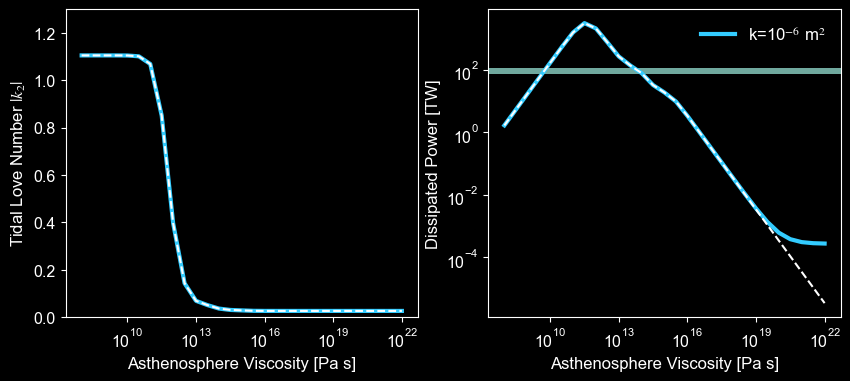

In [4]:
ηs = 8:0.5:22

res = 10.0
lons = deg2rad.(collect(0:res:360-0.001))'
clats = deg2rad.(collect(0:res:180))

lons_deg = rad2deg.(lons[:])
lats_deg = 90 .- rad2deg.(clats)
dres = deg2rad(res)

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
# println(size(axes))

colors = ["C1", "C2", "C3", "C4"]
cmap = PyPlot.cm.cool
colors = [0.2, 0.4, 0.6, 0.8]
cnt = 1
for j in -6:1:-6
    Edot = zeros(length(ηs))
    Edots = zeros(length(ηs))
    k_ln = zeros(ComplexF64, length(ηs))
    k_lns = zeros(ComplexF64, length(ηs))
    for i in eachindex(ηs)
        #######################################################################
        η[3] = 10.0^ηs[i] * (non_dim ? 1.0/(μ0*T) : 1.0)

        # k = 10^-j * eta_l 
        k[3] = 10.0^j * (non_dim ? 1.0/R^2 : 1.0)

        μc =  1im*ω*μ ./ (1im*ω .+ μ ./ η)

        # μc = μ

        y = ComplexF64.(calculate_y(r, ρ, g, μc, κ, ω, ρₗ, κₗ,κd, 0.95, ηₗ, ϕ, k))
        y2 = ComplexF64.(calculate_y(r, ρ, g, μc, κ))

        # display(y)

        yR = y[:,end,end]
        yR2 = y2[:,end,end]

        k2 = yR[5] - 1
        k22 = yR2[5] - 1

        k_ln[i] = k2
        k_lns[i] = k22
    
        # println(k2)

        # k2_2[i] = k2    # println("Porous body k2 = ", k2)  
        # println("k2 = ", yR[5] - 1)  
        # println("h2 = ", -g[end]*yR[1] )
        Edot[i] = 21/2 * -imag(k2) * (ω0*R)^5/G * e^2
        Edots[i] = 21/2 * -imag(k22) * (ω0*R)^5/G * e^2
        # println("Dissipated Energy Total: ", Ediss2/1e9)

       

    end

    axes[1].semilogx(10.0 .^ collect(ηs), abs.(k_ln), label="k=10\$^{$(j)}\$ m\$^{2}\$", color=cmap(colors[cnt]), lw=3.0)
    axes[1].semilogx(10.0 .^ collect(ηs), abs.(k_lns), "w--")

    axes[2].loglog(10.0 .^ collect(ηs), Edot/1e12, label="k=10\$^{$(j)}\$ m\$^{2}\$", color=cmap(colors[cnt]), lw=3.0)
    
    if j == -4 
        axes[2].loglog(10.0 .^ collect(ηs), Edots/1e12, "w--", label="no melt")
    else
        axes[2].loglog(10.0 .^ collect(ηs), Edots/1e12, "w--")
    end

    cnt += 1
end

axes[2].legend(frameon=false)

axes[1].set_ylabel("Tidal Love Number \$|k_2|\$")
axes[2].set_ylabel("Dissipated Power [TW]")
axes[1].set_xlabel("Asthenosphere Viscosity [Pa s]")
axes[2].set_xlabel("Asthenosphere Viscosity [Pa s]")

axes[2].axhspan((9.33-1.87)*1e13/1e12, (9.33+1.87)*1e13/1e12, alpha=0.8)
axes[1].set_ylim([0,1.3])
# fig.savefig("edot_-6.pdf", bbox_inches="tight", transparent=true, dpi=350)
display(fig)

